In [1]:
import scanpy as sc
from scipy.sparse import csc_matrix, csr_matrix, save_npz
from scipy.io import mmread, mmwrite
import numpy as np
import pandas as pd
from pathlib import Path
from os import path
import seaborn as sns

In [12]:
folder = '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/MouseKidney/' 
atac_anno = pd.read_csv('%s/ATAC/GSE157079_snATAC_metadata_filtered.csv' % folder, index_col=0).set_index('barcodes')
rna_anno = pd.read_csv('%s/RNA/GSE157079_P0_adult_clusters_filtered.csv' % folder, index_col=0).set_index('barcodes')

In [ ]:
atac_anno['barcodes_new'] = [y+'_'+x for x,y in zip(atac_anno.index, atac_anno.samples)]
atac_anno.set_index('barcodes_new', inplace=True)

In [17]:
folder = '/gpfs/gibbs/pi/zhao/xs272/Multiomics/sc_benchmark/data/kidney'

In [9]:
count = mmread('%s/RNA/counts.mtx' % folder)
adata_rna = sc.AnnData(count.tocsr())
del count
adata_rna.obs_names = pd.read_table('%s/RNA/cells.txt' % folder, header = None)[0].tolist()
adata_rna.var_names = pd.read_table('%s/RNA/genes.txt' % folder, header = None)[0].tolist()
adata_rna = adata_rna[rna_anno.index].copy()
adata_rna.obs = rna_anno

In [18]:
# workaround: remove all non-identifiable barcodes
count = mmread('%s/ATAC.gene.activities/counts.mtx' % folder)
adata_ga = sc.AnnData(count.tocsr())
del count
adata_ga.obs_names = pd.read_table('%s/ATAC.gene.activities/cells.txt' % folder, header = None)[0].tolist()
adata_ga.var_names = pd.read_table('%s/ATAC.gene.activities/genes.txt' % folder, header = None)[0].tolist()
# temp = atac_anno.index.value_counts()[atac_anno.index.value_counts() > 1].index
# adata_ga = adata_ga[~adata_ga.obs_names.isin(temp)]

In [26]:
adata_ga = adata_ga[atac_anno.index].copy()
adata_ga.obs = atac_anno

In [8]:
# adata_ga = adata_ga[atac_anno.index.intersection(adata_ga.obs_names)].copy()
# adata_ga.obs = atac_anno.loc[adata_ga.obs_names]

In [36]:
adata_rna.X.todense().max(1)

matrix([[ 45.],
        [489.],
        [229.],
        ...,
        [433.],
        [130.],
        [361.]], dtype=float32)

In [37]:
adata_ga.X.todense().max(1)

matrix([[19.],
        [32.],
        [32.],
        ...,
        [ 7.],
        [10.],
        [ 9.]], dtype=float32)

In [33]:
def simMatrix(adata, normalize=True, log=True, hvgs=2000, npcs=30, cell_type='annotation'):
    if normalize:
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    if log:
        sc.pp.log1p(adata)
    if hvgs:
        sc.pp.highly_variable_genes(adata, n_top_genes=hvgs)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)
    sc.pp.neighbors(adata, n_pcs=npcs)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=[cell_type], legend_loc='on data')
    sc.tl.paga(adata, groups=cell_type)
    sc.pl.paga(adata, color=[cell_type])
    pos = adata.uns['paga']['pos']
    D = np.zeros((pos.shape[0], pos.shape[0]))
    for i in range(D.shape[0]-1):
        for j in range(i+1,D.shape[0]):
            D[i,j] = (((pos[i,]-pos[j,])**2).sum())**.5
    D = D+D.transpose()
    ct = adata.obs[cell_type].cat.categories.tolist()
    sim = pd.DataFrame(np.exp(-D), index=ct, columns=ct)
    return sim

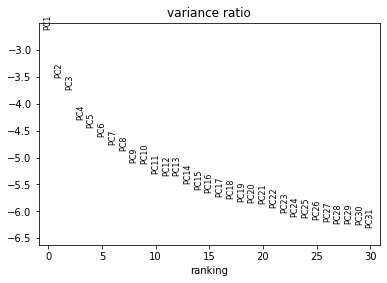

2022-08-02 23:59:39.337892: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ysm-gpfs/apps/software/GCCcore/10.2.0/lib64:/ysm-gpfs/apps/software/GCCcore/10.2.0/lib:/ysm-gpfs/apps/software/R/4.0.3-foss-2020b/lib64/R/lib:/ysm-gpfs/apps/software/R/4.0.3-foss-2020b/lib64:/ysm-gpfs/apps/software/nodejs/12.19.0-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/GLPK/4.65-GCCcore-10.2.0/lib:/gpfs/ysm/apps/software/ImageMagick/7.0.10-35-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/LittleCMS/2.11-GCCcore-10.2.0/lib:/gpfs/ysm/apps/software/JasPer/2.0.26-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/Ghostscript/9.53.3-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/Armadillo/10.2.1-foss-2020b/lib64:/ysm-gpfs/apps/software/arpack-ng/3.8.0-foss-2020b/lib:/ysm-gpfs/apps/software/Boost/1.74.0-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/GSL/2.6-GCCcor

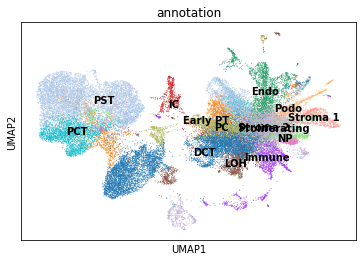

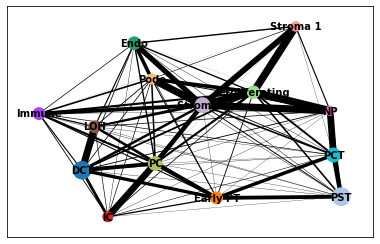

In [38]:
sim_rna = simMatrix(adata_rna)

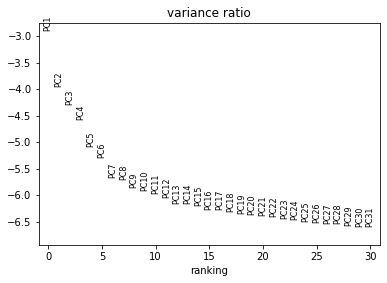

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'samples' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'clusters' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future v

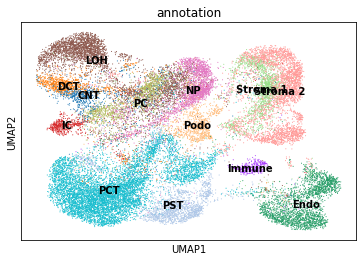

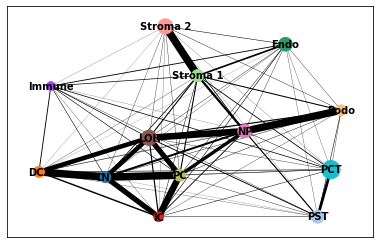

In [39]:
sim_atac = simMatrix(adata_ga)

In [40]:
sim_rna

,DCT,Early PT,Endo,IC,Immune,LOH,NP,PC,PCT,PST,Podo,Proliferating,Stroma 1,Stroma 2
DCT,1.000000,0.317955,0.147961,0.489850,0.406965,0.523502,0.115474,0.553955,0.133547,0.122627,0.234419,0.168308,0.066467,0.258314
Early PT,0.317955,1.000000,0.093997,0.402853,0.152696,0.240033,0.208786,0.495062,0.325271,0.371097,0.161643,0.205832,0.074591,0.254788
Endo,0.147961,0.093997,1.000000,0.077518,0.277392,0.282087,0.157654,0.169599,0.102073,0.061359,0.581403,0.304273,0.270346,0.346876
IC,0.489850,0.402853,0.077518,1.000000,0.199745,0.265277,0.094755,0.419662,0.133759,0.152522,0.128216,0.114615,0.042009,0.164614
Immune,0.406965,0.152696,0.277392,0.199745,1.000000,0.616826,0.098529,0.307253,0.088816,0.067429,0.356471,0.176256,0.089707,0.270594
LOH,0.523502,0.240033,0.282087,0.265277,0.616826,1.000000,0.151362,0.484708,0.142960,0.109195,0.433824,0.256290,0.113720,0.400823
NP,0.115474,0.208786,0.157654,0.094755,0.098529,0.151362,1.000000,0.203340,0.521851,0.282306,0.224220,0.512453,0.281309,0.360877
PC,0.553955,0.495062,0.169599,0.419662,0.307253,0.484708,0.203340,1.000000,0.240758,0.210550,0.288682,0.270515,0.099999,0.392139
PCT,0.133547,0.325271,0.102073,0.133759,0.088816,0.142960,0.521851,0.240758,1.000000,0.540673,0.160732,0.325797,0.147789,0.279675
PST,0.122627,0.371097,0.061359,0.152522,0.067429,0.109195,0.282306,0.210550,0.540673,1.000000,0.100808,0.185189,0.079967,0.175596


In [41]:
sim_atac

,CNT,DCT,Endo,IC,Immune,LOH,NP,PC,PCT,PST,Podo,Stroma 1,Stroma 2
CNT,1.000000,0.547910,0.068738,0.451051,0.213269,0.475565,0.235026,0.514192,0.132369,0.134944,0.093631,0.160568,0.083402
DCT,0.547910,1.000000,0.049039,0.274658,0.250074,0.323609,0.141717,0.283274,0.073199,0.074513,0.056031,0.122264,0.074223
Endo,0.068738,0.049039,1.000000,0.049781,0.110253,0.143897,0.235537,0.099190,0.127617,0.061438,0.308937,0.392707,0.328572
IC,0.451051,0.274658,0.049781,1.000000,0.098785,0.279702,0.206315,0.498983,0.179157,0.240875,0.093643,0.100513,0.046669
Immune,0.213269,0.250074,0.110253,0.098785,1.000000,0.297893,0.152659,0.158627,0.058105,0.041528,0.072205,0.265892,0.245643
LOH,0.475565,0.323609,0.143897,0.279702,0.297893,1.000000,0.422542,0.515984,0.181381,0.139219,0.169278,0.336142,0.165489
NP,0.235026,0.141717,0.235537,0.206315,0.152659,0.422542,1.000000,0.399956,0.371195,0.217903,0.395282,0.373023,0.160588
PC,0.514192,0.283274,0.099190,0.498983,0.158627,0.515984,0.399956,1.000000,0.257406,0.245793,0.168014,0.199947,0.090854
PCT,0.132369,0.073199,0.127617,0.179157,0.058105,0.181381,0.371195,0.257406,1.000000,0.464780,0.383236,0.145749,0.064515
PST,0.134944,0.074513,0.061438,0.240875,0.041528,0.139219,0.217903,0.245793,0.464780,1.000000,0.178261,0.081283,0.035023


<AxesSubplot:>

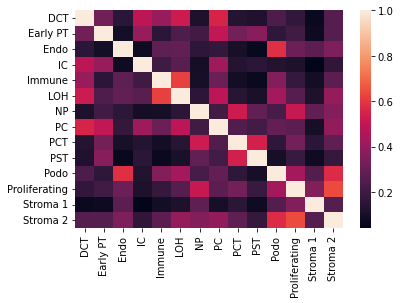

In [42]:
sns.heatmap(sim_rna)

<AxesSubplot:>

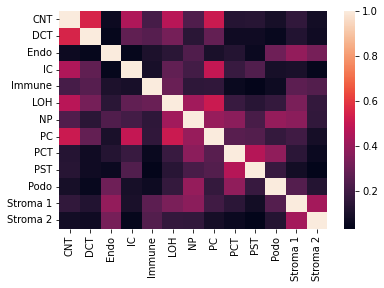

In [43]:
sns.heatmap(sim_atac)

In [44]:
def crossOmicSimMatrix(sim_rna, sim_atac):
    
    ct_rna = sim_rna.index.tolist()
    ct_atac = sim_atac.index.tolist()

    # common cell types
    ct_common = list(set(ct_rna).intersection(ct_atac))

    # rna unique cell types
    ct_rna_only = list(set(ct_rna).difference(ct_atac))

    # atac unique cell types
    ct_atac_only = list(set(ct_atac).difference(ct_rna))
    
    sim = np.zeros((len(ct_atac), len(ct_rna)))
    
    # common to common
    sim[:len(ct_common), :len(ct_common)] = (sim_rna.loc[ct_common, ct_common] + sim_atac.loc[ct_common, ct_common])/2
    
    # atac unique to common
    sim[len(ct_common):, :len(ct_common)] = sim_atac.loc[ct_atac_only, ct_common]
    
    # common to rna unique
    sim[:len(ct_common), len(ct_common):] = sim_rna.loc[ct_common, ct_rna_only]
    
    # atac unique to rna unique
    temp1 = sim_atac.loc[ct_atac_only, ct_common]
    temp1[temp1 < 0.5] = 0
    temp2 = sim_rna.loc[ct_common, ct_rna_only]
    denom = (temp1 != 0).sum(1).values.reshape((-1,1))
    sim[len(ct_common):, len(ct_common):] = (temp1.values @ temp2.values) / denom
    
    sim = pd.DataFrame(sim, index = ct_common + ct_atac_only, columns =  ct_common + ct_rna_only).fillna(0)
    
    return sim

In [45]:
sim = crossOmicSimMatrix(sim_rna, sim_atac)

In [46]:
sim

,Podo,Stroma 1,Immune,NP,Stroma 2,PST,IC,PCT,PC,LOH,Endo,DCT,Early PT,Proliferating
Podo,1.000000,0.248863,0.214338,0.309751,0.348958,0.139534,0.110929,0.271984,0.228348,0.301551,0.445170,0.145225,0.161643,0.434745
Stroma 1,0.248863,1.000000,0.177799,0.327166,0.341490,0.080625,0.071261,0.146769,0.149973,0.224931,0.331526,0.094365,0.074591,0.359907
Immune,0.214338,0.177799,1.000000,0.125594,0.258119,0.054478,0.149265,0.073461,0.232940,0.457360,0.193822,0.328520,0.152696,0.176256
NP,0.309751,0.327166,0.125594,1.000000,0.260733,0.250105,0.150535,0.446523,0.301648,0.286952,0.196596,0.128595,0.208786,0.512453
Stroma 2,0.348958,0.341490,0.258119,0.260733,1.000000,0.105309,0.105641,0.172095,0.241497,0.283156,0.337724,0.166268,0.254788,0.638704
PST,0.139534,0.080625,0.054478,0.250105,0.105309,1.000000,0.196698,0.502726,0.228171,0.124207,0.061399,0.098570,0.371097,0.185189
IC,0.110929,0.071261,0.149265,0.150535,0.105641,0.196698,1.000000,0.156458,0.459323,0.272489,0.063649,0.382254,0.402853,0.114615
PCT,0.271984,0.146769,0.073461,0.446523,0.172095,0.502726,0.156458,1.000000,0.249082,0.162171,0.114845,0.103373,0.325271,0.325797
PC,0.228348,0.149973,0.232940,0.301648,0.241497,0.228171,0.459323,0.249082,1.000000,0.500346,0.134394,0.418615,0.495062,0.270515
LOH,0.301551,0.224931,0.457360,0.286952,0.283156,0.124207,0.272489,0.162171,0.500346,1.000000,0.212992,0.423555,0.240033,0.256290


In [24]:
# old
sim

,LOH,Immune,PC,PCT,Stroma 1,DCT,Podo,Stroma 2,IC,NP,Endo,PST,Early PT,Proliferating
LOH,1.000000,0.278783,0.443020,0.092787,0.178867,0.485906,0.272268,0.205444,0.243011,0.284633,0.241056,0.092578,0.172707,0.187641
Immune,0.278783,1.000000,0.334997,0.200532,0.211252,0.229522,0.210432,0.295782,0.181871,0.265203,0.255019,0.181468,0.495010,0.397918
PC,0.443020,0.334997,1.000000,0.162618,0.164705,0.444440,0.296382,0.240193,0.469106,0.342668,0.149697,0.193040,0.412543,0.257808
PCT,0.092787,0.200532,0.162618,1.000000,0.189312,0.073891,0.293980,0.266146,0.126946,0.351976,0.087689,0.459164,0.246684,0.331679
Stroma 1,0.178867,0.211252,0.164705,0.189312,1.000000,0.090065,0.373977,0.378596,0.087940,0.366232,0.285564,0.111395,0.070049,0.350829
DCT,0.485906,0.229522,0.444440,0.073891,0.090065,1.000000,0.165063,0.149616,0.325648,0.154124,0.133882,0.084078,0.265822,0.168627
Podo,0.272268,0.210432,0.296382,0.293980,0.373977,0.165063,1.000000,0.468686,0.180173,0.360778,0.361976,0.214631,0.142506,0.448997
Stroma 2,0.205444,0.295782,0.240193,0.266146,0.378596,0.149616,0.468686,1.000000,0.120973,0.283088,0.316668,0.149787,0.221754,0.650906
IC,0.243011,0.181871,0.469106,0.126946,0.087940,0.325648,0.180173,0.120973,1.000000,0.183972,0.073573,0.212274,0.404070,0.121517
NP,0.284633,0.265203,0.342668,0.351976,0.366232,0.154124,0.360778,0.283088,0.183972,1.000000,0.151974,0.235279,0.163557,0.515209


In [127]:
# old
sim

,IC,PC,Stroma 2,PCT,NP,LOH,Podo,Immune,PST,Stroma 1,DCT,Endo,Proliferating,Early PT
IC,1.000000,0.480775,0.114207,0.145618,0.174928,0.258491,0.126024,0.202509,0.228345,0.085783,0.341023,0.079165,0.121517,0.404070
PC,0.480775,1.000000,0.242055,0.198169,0.318443,0.460466,0.243628,0.343644,0.222528,0.172403,0.460712,0.159653,0.257808,0.412543
Stroma 2,0.114207,0.242055,1.000000,0.190365,0.291804,0.245031,0.474527,0.266117,0.121412,0.393020,0.174723,0.304777,0.650906,0.221754
PCT,0.145618,0.198169,0.190365,1.000000,0.415395,0.124403,0.270142,0.190388,0.480448,0.159940,0.090291,0.070781,0.331679,0.246684
NP,0.174928,0.318443,0.291804,0.415395,1.000000,0.285725,0.340851,0.210899,0.261839,0.359140,0.158748,0.140614,0.515209,0.163557
LOH,0.258491,0.460466,0.245031,0.124403,0.285725,1.000000,0.274336,0.263222,0.113905,0.251948,0.505893,0.281521,0.187641,0.172707
Podo,0.126024,0.243628,0.474527,0.270142,0.340851,0.274336,1.000000,0.173697,0.146965,0.346798,0.164045,0.347932,0.448997,0.142506
Immune,0.202509,0.343644,0.266117,0.190388,0.210899,0.263222,0.173697,1.000000,0.180748,0.150505,0.405300,0.203201,0.397918,0.495010
PST,0.228345,0.222528,0.121412,0.480448,0.261839,0.113905,0.146965,0.180748,1.000000,0.095979,0.097068,0.049434,0.205925,0.330293
Stroma 1,0.085783,0.172403,0.393020,0.159940,0.359140,0.251948,0.346798,0.150505,0.095979,1.000000,0.136535,0.271079,0.350829,0.070049


<AxesSubplot:>

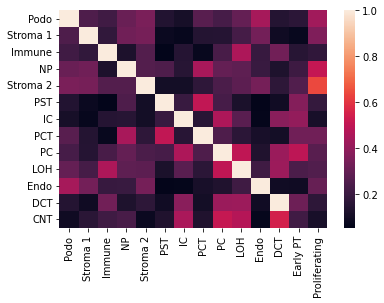

In [47]:
sns.heatmap(sim)

<AxesSubplot:>

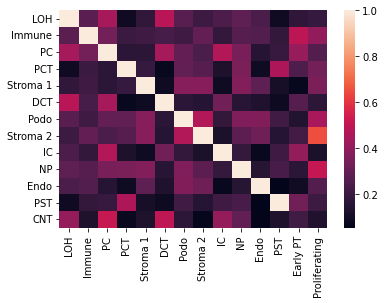

In [25]:
sns.heatmap(sim)

In [48]:
# save
sim.to_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/data/MouseKidney/sim_kidney.csv')